# Simple Backpropagation in python

Here we will do the steps of backpropagation in python.

Our goal will be this.  Given input $a$ compute:

$$p = e^{-a^2}$$

$$f = \text{mean}(p, p^2) = \frac{p + p^2}{2}$$

$$\text{gradient} = \frac{\partial f}{\partial a}$$





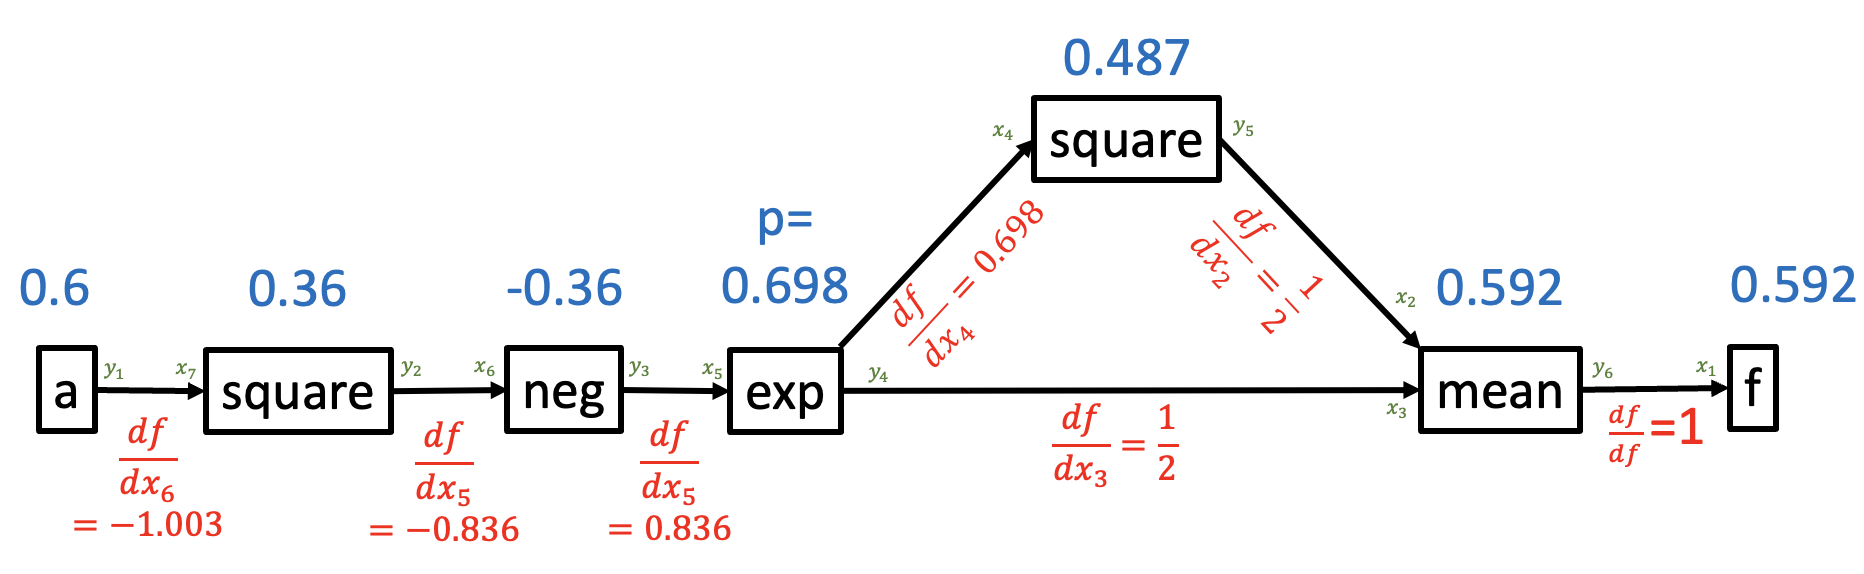

The code from last class is here, plus three extra nodes for "neg", "exp" and "pow".

Review it carefully and remember what we worked on last time.

This time we will add a bit of the "backward" pass.

In [11]:
import math

class ComputationNode:
    def __init__(self, *input_nodes, name=None):
        self.name = name
        self.input_nodes = [
            n if isinstance(n, ComputationNode)
            else Leaf(n) for n in input_nodes]
    def __init__(self, *input_nodes, name=None):
        self.name = name
        self.input_nodes = [
            n if isinstance(n, ComputationNode)
            else Leaf(n)
            for n in input_nodes]

    def __sub__(self, other):
        return Sub(self, other)
    def __mul__(self, other):
        return Mul(self, other)
    def __neg__(self):
        return Neg(self)
    def __pow__(self, int_power):
        return IntPow(self, int_power)
    def exp(self):
        return Exp(self)

    def sorted_nodes(self, seen=None, result=None):
        if seen is None: seen, result = set(), []
        if self in seen: return result
        seen.add(self)
        for node in self.input_nodes:
            node.sorted_nodes(seen, result)
        result.append(self)
        return result

    # Predefine a recursive print-out that makes recursive indented outputs.
    def __repr__(self):
        return self.tree_repr({})
    def tree_repr(self, seen):
        '''Print out the node and its inputs recursively so you can see the graph.'''
        if self in seen: return seen[self]
        seen[self] = (f'{type(self).__name__}#{len(seen) + 1}' +
               ''.join(f', {a}={getattr(self, a)}' for a in vars(self)
                  if '_' not in a and getattr(self, a) is not None))
        return '\n  '.join('\n'.join([seen[self]] +
             [node.tree_repr(seen) for node in self.input_nodes]).split('\n'))

class Leaf(ComputationNode):
    def __init__(self, value, name=None):
        super().__init__(name=name)
        self.value = value
    def forward(self):
        self.result = self.value

class Sub(ComputationNode):
    def __init__(self, a, b, name=None):
        super().__init__(a, b, name=name)
    def forward(self):
        self.result = self.input_nodes[0].result - self.input_nodes[1].result

class Mul(ComputationNode):
    def __init__(self, a, b, name=None):
        super().__init__(a, b, name=name)
    def forward(self):
        self.result = self.input_nodes[0].result * self.input_nodes[1].result

class IntPow(ComputationNode):
    def __init__(self, a, int_pow, name=None):
        super().__init__(a, name=name)
        self.int_pow = int_pow
    def forward(self):
        self.result = self.input_nodes[0].result ** self.int_pow

class Mean(ComputationNode):
    def __init__(self, a, b, name=None):
        super().__init__(a, b, name=name)
    def forward(self):
        self.result = (self.input_nodes[0].result + self.input_nodes[1].result) / 2

class Neg(ComputationNode):
    def __init__(self, a, name=None):
        super().__init__(a, name=name)
    def forward(self):
        self.result = -self.input_nodes[0].result

class Exp(ComputationNode):
    def __init__(self, a, name=None):
        super().__init__(a, name=name)
    def forward(self):
        self.result = math.exp(self.input_nodes[0].result)

def forward_pass(root):
    node_list = root.sorted_nodes()
    for node in node_list:
        print(root, '\n') # TODO: remove this later to make the function quieter
        node.forward()
    return root.result

## Reviewing the Forward Pass

Here is the forward pass for our sample expression.

If you run it, you can see the shape of the graph, and you can see the order in which the forward pass is run.

In [ ]:
a = Leaf(0.6, name='a')
p = (-a**2).exp()
root = Mean(p, p**2)
forward_pass(root)
print(root, '\n')

print(f'The answer is {root.result}')

## A First Piece for the Backward Pass: the Mean Node

Now, to implement the backward pass, we will make sure that every node has a `backward()` method.

The job of the `backward` method will be to:
1. compute the "internal" gradient of the *local* output with respect to each *local* input.
2. apply the chain rule by multiplying the upstream gradient with each component of the local gradient.
3. save each component of the chained result as the downstream gradient corresponding to each local input.

For example, the `Mean` node:
1. has a local gradient of `1/2` with respect to each of its two inputs.
2. so, by the chain rule, it should halve the upstream gradient
3. and it should propagate this halved gradient to each downstream gradient.

In code it could look like this
```
class Mean(ComputationNode):
    # [... skipping previous methods]
    def backward(self):
        upstream = self.grad
        for n in self.input_nodes:
            n.grad = upstream / 2
```

Copy this "backward" method to the `Mean` class definition above.

(Warning: there is a subtle bug in this, and we will fix it soon.)

## Implementing the internal gradient for negation and exponentiation

Similarly, we can encode the rules of ordinary calculus into the Neg, IntPow, and Exp nodes.

For negation:
$$\frac{\partial}{\partial x} -x = -1$$
So copy this above:
```
class Neg(ComputationNode):
    # [... skipping previous methods]
    def backward(self):
        upstream = self.grad
        self.input_nodes[0].grad = -upstream
```

The power rule:
$$\frac{\partial}{\partial x} x^n = n x^{n-1}$$
so copy this:
```
class IntPow(ComputationNode):
    # [... skipping previous methods]
    def backward(self):
        upstream = self.grad
        self.input_nodes[0].grad = upstream * (
          self.int_pow * self.input_nodes[0].result ** (self.int_pow - 1))
```

And the derivative of the natural exponent:
$$\frac{\partial}{\partial x} e^{x} = e^{x}$$
so copy this:
```
class Exp(ComputationNode):
    # [... skipping previous methods]
    def backward(self):
        upstream = self.grad
        self.input_nodes[0].grad = upstream * self.result
```

## Testing the backward pass

Now try this.  Is the answer right?

In [ ]:
a = Leaf(0.6, name='a')
p = (-a**2).exp()
root = Mean(p, p**2)
forward_pass(root)
print(root, '\n')

print(f'The answer is {root.result}')

all_nodes = root.sorted_nodes()
root.grad = 1.0
print(0, root, '\n')
for n, node in enumerate(reversed(all_nodes)):
    node.backward()
    print(n+1, node, '\n')



## Adding Gradient Accumulation To Handle Multiple Paths

If you get a result like $-0.584$ that is very far from $-1$, then it is wrong.

But notice how that happened!  How did it get it wrong?

After step 1, the Exp node (the same as the variable $p$) has grad 0.5.  But then after step 2, that same Exp node has a grad that has been overwritten as 0.698!   Which of these conflicting gradients is the right one?

Turns out: neither.  The right answer is that the actual gradient is the sum of all the derivative contributions computed over all computations paths.  We need to *accumulate gradients* over all the paths.

Write the following function in the base `ComputationNode` class and then write use it in every `backward` method.  Here is the function:
```
    def accumulate_grad(self, g):
        self.grad = (self.grad or 0.0) + g
```

To use it, every `backward` method should call `accumulate_grad` instead of saying `n.grad = X`.  For example, in the `Mean` node:

```
class Mean(ComputationNode):
    # [... skipping previous methods]
    def backward(self):
        upstream = self.grad
        for n in self.input_nodes:
            n.accumulate_grad(upstream / 2)
```

Update `Mean`, `IntPow`, `Neg`, and `Exp` accordingly.

Now if you re-run the code above, it should work.

The right answer is about -1.002.

## About Gradient Accumulation and Zeroing Gradients

A key takeway from above is that gradient accumulation is a fundamental part of the backpropagation algorithm.

In pytorch, before you start a `.backward()` pass, if you already have some numbers in the `.grad` field of a tensor, then the computed gradient will be *accumulated* and added to those previous numbers.

So you if there's a chance that there is an old gradient, will need to call `network.zero_grad()` (or simply set `x.grad = 0` for each parameter) before each call to `loss.backward()`.

### Completed solution below.

For your reference

In [8]:
"""
import math

class ComputationNode:
    def __init__(self, *input_nodes, name=None):
        self.name = name
        self.input_nodes = [
            n if isinstance(n, ComputationNode)
            else Leaf(n) for n in input_nodes]
    def __init__(self, *input_nodes, name=None):
        self.name = name
        self.input_nodes = [
            n if isinstance(n, ComputationNode)
            else Leaf(n)
            for n in input_nodes]
    def accumulate_grad(self, g):
        self.grad = getattr(self, 'grad', 0.0) + g

    def __sub__(self, other):
        return Sub(self, other)
    def __mul__(self, other):
        return Mul(self, other)
    def __neg__(self):
        return Neg(self)
    def __pow__(self, int_power):
        return IntPow(self, int_power)
    def exp(self):
        return Exp(self)

    def sorted_nodes(self, seen=None, result=None):
        if seen is None: seen, result = set(), []
        if self in seen: return result
        seen.add(self)
        for node in self.input_nodes:
            node.sorted_nodes(seen, result)
        result.append(self)
        return result

    # Predefine a recursive print-out that makes recursive indented outputs.
    def __repr__(self):
        return self.tree_repr({})
    def tree_repr(self, seen):
        '''Print out the node and its inputs recursively so you can see the graph.'''
        if self in seen: return seen[self]
        seen[self] = (f'{type(self).__name__}#{len(seen) + 1}' +
               ''.join(f', {a}={getattr(self, a)}' for a in vars(self)
                  if '_' not in a and getattr(self, a) is not None))
        return '\n  '.join('\n'.join([seen[self]] +
             [node.tree_repr(seen) for node in self.input_nodes]).split('\n'))

class Leaf(ComputationNode):
    def __init__(self, value, name=None):
        super().__init__(name=name)
        self.value = value
    def forward(self):
        self.result = self.value
    def backward(self):
        pass

class Sub(ComputationNode):
    def __init__(self, a, b, name=None):
        super().__init__(a, b, name=name)
    def forward(self):
        self.result = self.input_nodes[0].result - self.input_nodes[1].result

class Mul(ComputationNode):
    def __init__(self, a, b, name=None):
        super().__init__(a, b, name=name)
    def forward(self):
        self.result = self.input_nodes[0].result * self.input_nodes[1].result

class IntPow(ComputationNode):
    def __init__(self, a, int_pow, name=None):
        super().__init__(a, name=name)
        self.int_pow = int_pow
    def forward(self):
        self.result = self.input_nodes[0].result ** self.int_pow
    def backward(self):
        upstream = self.grad
        self.input_nodes[0].accumulate_grad(upstream * (
          self.int_pow * self.input_nodes[0].result ** (self.int_pow - 1)))

class Mean(ComputationNode):
    def __init__(self, a, b, name=None):
        super().__init__(a, b, name=name)
    def forward(self):
        self.result = (self.input_nodes[0].result + self.input_nodes[1].result) / 2
    def backward(self):
        upstream = self.grad
        for n in self.input_nodes:
            n.accumulate_grad(upstream / 2)

class Neg(ComputationNode):
    def __init__(self, a, name=None):
        super().__init__(a, name=name)
    def forward(self):
        self.result = -self.input_nodes[0].result
    def backward(self):
        upstream = self.grad
        self.input_nodes[0].accumulate_grad(-upstream)

class Exp(ComputationNode):
    def __init__(self, a, name=None):
        super().__init__(a, name=name)
    def forward(self):
        self.result = math.exp(self.input_nodes[0].result)
    def backward(self):
        upstream = self.grad
        self.input_nodes[0].accumulate_grad(upstream * self.result)

def forward_pass(root):
    node_list = root.sorted_nodes()
    for node in node_list:
        node.forward()
    return root.result
"""